In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### Data Preprocessing

In [22]:

# Load the final dataset created in the data analysis notebook
df = pd.read_csv('../data_analysis/final_dataset.csv')

# Combine non-alphabetical characters removal and lowercase conversion into one step
df['text'] = df['text'].str.replace(r'[^a-zA-Z0-9\s]', '').str.lower()
# Split 80% for training and 20% for validation and testing combined
train_df, val_test_df = train_test_split(df, test_size=0.2, random_state=42)

# Split the remaining 20% into equal parts for validation and testing (10% each)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=42)

# Print the sizes of each dataset
print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))
print("Testing set size:", len(test_df))

# Count the occurrences of AI-generated and human-written labels in the testing set
label_counts = test_df['label'].value_counts()
ai_generated_count = label_counts[1]
human_written_count = label_counts[0]
print("AI-generated labels:", ai_generated_count)
print("Human-written labels:", human_written_count)

C:\Users\41787\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


Training set size: 54235
Validation set size: 6779
Testing set size: 6780
AI-generated labels: 3429
Human-written labels: 3351


In [7]:

# Define pre-processing parameters
max_len = 500 
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # out of vocabulary token
vocab_size = 1000

# Initialize the Tokenizer
tokenizer = Tokenizer(num_words=vocab_size, 
                      char_level=False,
                      oov_token=oov_tok)

# Fit the tokenizer on the training data
tokenizer.fit_on_texts(train_df['text'])
tokenizer.fit_on_texts(val_df['text'])  # Fit on validation data as well to ensure consistent word indices


# Get the word_index
word_index = tokenizer.word_index
total_words = len(word_index)

# Convert text data to sequences of integers
train_sequences = tokenizer.texts_to_sequences(train_df['text'])
val_sequences = tokenizer.texts_to_sequences(val_df['text'])
test_sequences = tokenizer.texts_to_sequences(test_df['text'])

padded_train_sequences = pad_sequences(train_sequences, maxlen=max_len, truncating=trunc_type, padding=padding_type)
padded_val_sequences = pad_sequences(val_sequences, maxlen=max_len, truncating=trunc_type, padding=padding_type)
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_len, truncating=trunc_type, padding=padding_type)

In [8]:
#Printing the shapes of padded dataset sequences
print('Shape of training tensor: ', padded_train_sequences.shape)
print('Shape of testing tensor: ', padded_val_sequences.shape)
print('Shape of testing tensor: ', padded_test_sequences.shape)

train_labels = train_df['label'].values
val_labels = val_df['label'].values
test_labels = test_df['label'].values


Shape of training tensor:  (54235, 500)
Shape of testing tensor:  (6779, 500)
Shape of testing tensor:  (6780, 500)


In [9]:
# Creation of the bi-LSTM model 
# Define model parameters
embedding_dim = 128
n_lstm = 64
drop_lstm = 0.2

model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size,
                     output_dim=embedding_dim,
                     input_length=max_len))
# Add a Bidirectional LSTM layer
model2.add(Bidirectional(LSTM(units=n_lstm, return_sequences=False)))
# Add dropout
model2.add(Dropout(rate=drop_lstm))
# Add a Dense layer without activation for logits
model2.add(Dense(units=1, activation=None))
# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Print the model summary
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          128000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 226,945
Trainable params: 226,945
Non-trainable params: 0
_________________________________________________________________


### Model Training

In [10]:
# Define the callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
checkpoint_filepath = "models/newLstm/best_model.h5"

checkpointer = ModelCheckpoint(
        moniter='val_loss',
        filepath=checkpoint_filepath,
        mode='min',
        verbose=1,
        save_best_only=True
    )
# Fit the model
history = model2.fit(padded_train_sequences,
                     train_labels,
                     batch_size=32,
                     epochs=30,
                     validation_data=(padded_val_sequences, val_labels),
                     callbacks =[checkpointer])

Epoch 1/30
1695/1695 [==============================] - ETA: 0s - loss: 0.5593 - accuracy: 0.6877
Epoch 1: val_loss improved from inf to 0.48543, saving model to newLstm\best_model.h5
1695/1695 [==============================] - 693s 407ms/step - loss: 0.5593 - accuracy: 0.6877 - val_loss: 0.4854 - val_accuracy: 0.7320
Epoch 2/30
1695/1695 [==============================] - ETA: 0s - loss: 0.5082 - accuracy: 0.7239
Epoch 2: val_loss did not improve from 0.48543
1695/1695 [==============================] - 686s 405ms/step - loss: 0.5082 - accuracy: 0.7239 - val_loss: 0.4882 - val_accuracy: 0.7365
Epoch 3/30
1695/1695 [==============================] - ETA: 0s - loss: 0.4836 - accuracy: 0.7427
Epoch 3: val_loss did not improve from 0.48543
1695/1695 [==============================] - 653s 385ms/step - loss: 0.4836 - accuracy: 0.7427 - val_loss: 0.5110 - val_accuracy: 0.7449
Epoch 4/30
1695/1695 [==============================] - ETA: 0s - loss: 0.4654 - accuracy: 0.7565
Epoch 4: val_loss

In [12]:
model_path = "models/newLstm/"

# Save the model
model2.save(model_path)

INFO:tensorflow:Assets written to: newLstm/assets


INFO:tensorflow:Assets written to: newLstm/assets


### Testing and Evaluation

In [13]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model2.evaluate(padded_val_sequences, val_labels)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')


212/212 [==============================] - 29s 137ms/step - loss: 0.3140 - accuracy: 0.8947
Validation Loss: 0.31398022174835205, Validation Accuracy: 0.8946747183799744


In [14]:
# Evaluate the model on the test set
test_loss, test_accuracy = model2.evaluate(padded_test_sequences, test_df['label'], verbose=0)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

Test Loss: 0.3218704164028168, Test Accuracy: 0.889675498008728


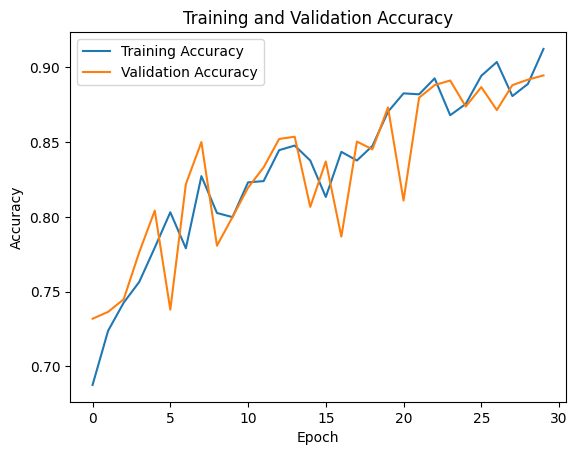

In [15]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

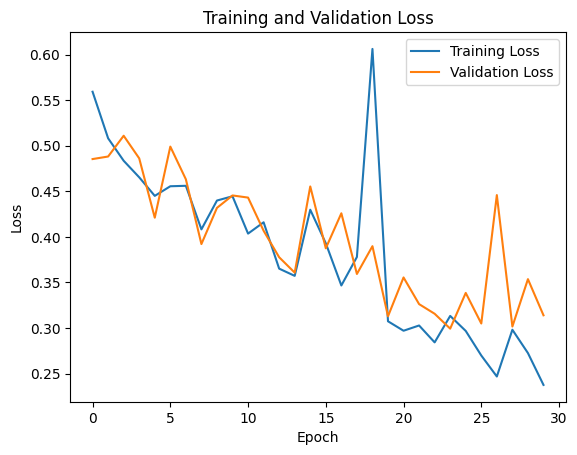

In [16]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

212/212 [==============================] - 18s 82ms/step


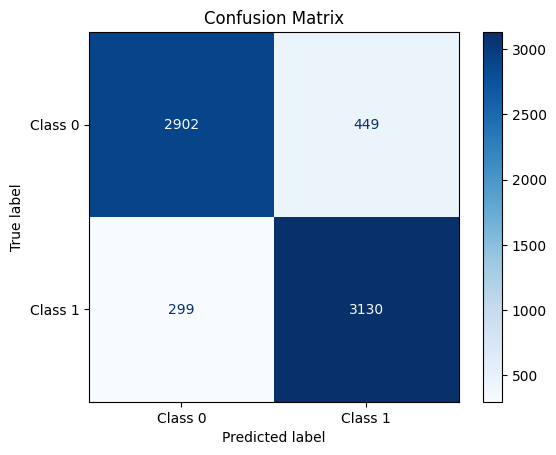

In [17]:
# provides a comprehensive breakdown of the model's predictions versus the actual class labels.
# Predict probabilities for the test set
probabilities = model2.predict(padded_test_sequences)
predictions = (probabilities > 0.5).astype(int)  # Thresholding at 0.5

# Generate confusion matrix
cm = confusion_matrix(test_labels, predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()



212/212 [==============================] - 17s 79ms/step


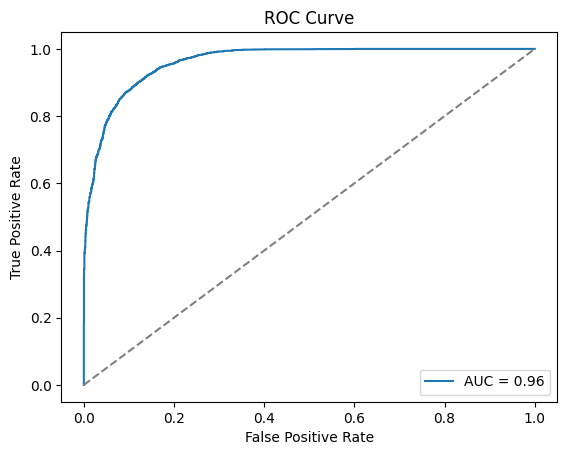

In [18]:
#visualizes the trade-off between true positive rate (sensitivity) and false positive rate (1 - specificity) across different threshold values.
# Get probabilities for positive class
probabilities = model2.predict(padded_test_sequences)
auc_score = roc_auc_score(test_labels, probabilities)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, probabilities)

# Plot ROC curve
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [19]:

probabilities = model2.predict(padded_test_sequences)
predictions = (probabilities > 0.5).astype(int)


accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions)
recall = recall_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions)

print(f'Test Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

212/212 [==============================] - 17s 80ms/step
Test Accuracy: 0.8896755162241888
Precision: 0.8745459625593741
Recall: 0.9128025663458734
F1 Score: 0.8932648401826484
